# Data exploration of the CFIS-W3 lensing catalog

In this notebook, we are using the non-public data of the **full CFIS-W3 field** (50 deg^2) provided elsewhere.

In [1]:
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


/Users/mkilbing/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 1st session
07/10/2021
Look at some basic quantities in catalogue (positions, flags, magnitude, ...)

In [2]:
# Load catalogue (numpy file)
dd = np.load('./catalogue_CFIS_W3/final_cat.npy')

**SExtractor denominations:**

- XWIN_WORLD: RA
- YWIN_WORLD: DEC

Shape measurement is done with two methods
- ngmix (preferred): model fitting (mixture of gaussians) on multi-epoch images, easy to process metacalibration with it
- galsim (depreciated): quadrupole moment measurements on stacks, shear estimate looks very biases probably due to inaccurate stacked PSF model

In [3]:
# Show column names
print(dd.dtype.names)

('XWIN_WORLD', 'YWIN_WORLD', 'TILE_ID', 'FLAGS', 'IMAFLAGS_ISO', 'NGMIX_MCAL_FLAGS', 'NGMIX_ELL_PSFo_NOSHEAR', 'GALSIM_PSF_ELL_ORIGINAL_PSF', 'SPREAD_CLASS', 'SPREAD_MODEL', 'SPREADERR_MODEL', 'N_EPOCH', 'NGMIX_N_EPOCH', 'NGMIX_ELL_1M', 'NGMIX_ELL_1P', 'NGMIX_ELL_2M', 'NGMIX_ELL_2P', 'NGMIX_ELL_NOSHEAR', 'NGMIX_ELL_ERR_NOSHEAR', 'NGMIX_FLAGS_1M', 'NGMIX_FLAGS_1P', 'NGMIX_FLAGS_2M', 'NGMIX_FLAGS_2P', 'NGMIX_FLAGS_NOSHEAR', 'NGMIX_T_1M', 'NGMIX_T_1P', 'NGMIX_T_2M', 'NGMIX_T_2P', 'NGMIX_T_NOSHEAR', 'NGMIX_T_ERR_1M', 'NGMIX_T_ERR_1P', 'NGMIX_T_ERR_2M', 'NGMIX_T_ERR_2P', 'NGMIX_T_ERR_NOSHEAR', 'NGMIX_Tpsf_1M', 'NGMIX_Tpsf_1P', 'NGMIX_Tpsf_2M', 'NGMIX_Tpsf_2P', 'NGMIX_Tpsf_NOSHEAR', 'NGMIX_FLUX_1M', 'NGMIX_FLUX_1P', 'NGMIX_FLUX_2M', 'NGMIX_FLUX_2P', 'NGMIX_FLUX_NOSHEAR', 'NGMIX_FLUX_ERR_1M', 'NGMIX_FLUX_ERR_1P', 'NGMIX_FLUX_ERR_2M', 'NGMIX_FLUX_ERR_2P', 'NGMIX_FLUX_ERR_NOSHEAR', 'GALSIM_GAL_ELL_1M', 'GALSIM_GAL_ELL_1P', 'GALSIM_GAL_ELL_2M', 'GALSIM_GAL_ELL_2P', 'GALSIM_GAL_ELL_NOSHEAR', 'GAL

How many objects do we have?

In [4]:
len(dd)

5367032

Map the distribution of objects on the sky

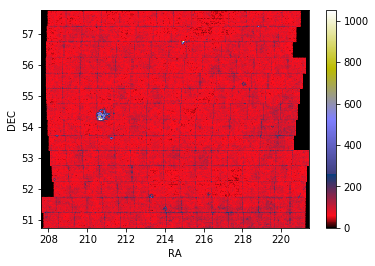

In [5]:
hist2d(dd['XWIN_WORLD'], dd['YWIN_WORLD'], 256, cmap='gist_stern');
xlabel('RA')
ylabel('DEC')
_ = colorbar()

Apply some masking to the catalog

In [6]:
# FLAG_TILING = 0: duplicate objects due to overlapping tiles
# FLAGS != 0: SExtractor mask
# IMAFLAGS_ISO != 0: masked objects (bright stars, Messier objects, chip defects, ...)
# NGMIX_ELL_NOSHEAR = -10: invalid measurement (e.g. invalid PSF)
# NGMIX_FLAGS_NOSHEAR != 1: failed shape measurement

mask = (dd['FLAG_TILING'] == 1) & (dd['FLAGS']==0) \
  & (dd['IMAFLAGS_ISO'] == 0) \
  & (dd['NGMIX_ELL_NOSHEAR'][:,0] > -10) \
  & (dd['NGMIX_FLAGS_NOSHEAR'] != 1)[0]

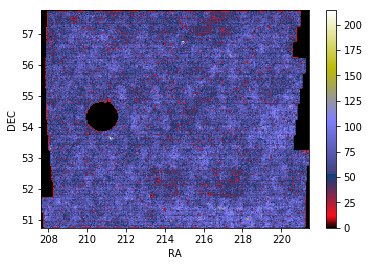

In [7]:
hist2d(dd['XWIN_WORLD'][mask], dd['YWIN_WORLD'][mask], 256, cmap='gist_stern');
xlabel('RA')
ylabel('DEC')
_ = colorbar()

r band magnitude distribution

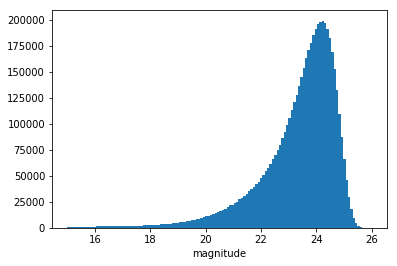

In [8]:
hist(dd['MAG_AUTO'], range=(15,26), bins=128);
_ = xlabel('magnitude')

r band SNR distribution

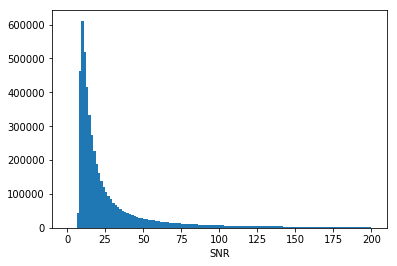

In [9]:
hist(dd['SNR_WIN'], range=(0,200), bins=128);
_ = xlabel('SNR')

Mean ellipticity

In [10]:
print(dd['NGMIX_ELL_NOSHEAR'].shape)
print('mean e1', np.mean(dd['NGMIX_ELL_NOSHEAR'][:,0][mask]))
print('mean e2', np.mean(dd['NGMIX_ELL_NOSHEAR'][:,1][mask]))

(5367032, 2)
mean e1 -0.000571487291621
mean e2 0.000432834855408


## 2nd session
14/10/2021
Exploring in more detail galaxy selection.
Loading star catalogue

SPREAD_CLASS classification

(Depreciated, we will use SPREAD_MODEL later.)

Note that only galaxies will be selected on the stacks. Stars have been detected on the single exposures, this provides a more homogeneous star sample. We will look at the (validation) star catalogue later.

0: stars
1: galaxies
2: artefacts

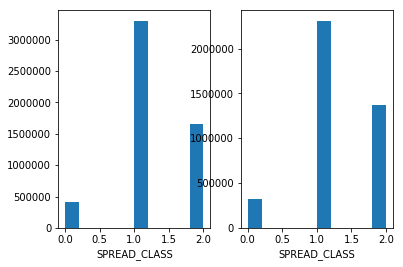

In [13]:
# Plot distribution
subplot(121)
_ = hist(dd['SPREAD_CLASS'])
_ = xlabel('SPREAD_CLASS')

subplot(122)
_ = hist(dd['SPREAD_CLASS'][mask])
_ = xlabel('SPREAD_CLASS')

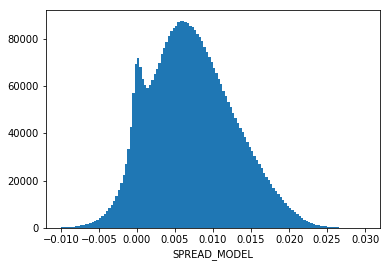

In [15]:
# Preferred classification: SPREAD_MODEL
# See SExtractor documentation https://sextractor.readthedocs.io/en/latest/Model.html#model-based-star-galaxy-separation-spread-model
# Here, this flag is computed by the ShapePipe implementation of the spread model

# Plot distribution
_ = hist(dd['SPREAD_MODEL'][mask], range=[-0.01, 0.03], bins=128)
_ = xlabel('SPREAD_MODEL')

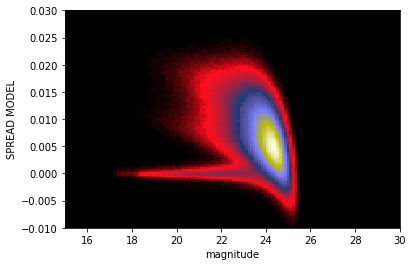

In [16]:
# Typically, one plots the 2D distribution of magnitude and spread model, to identify the *stellar locus*, i.e.
# a number of objects with more or less the same size

_ = hist2d(dd['MAG_AUTO'][mask], dd['SPREAD_MODEL'][mask], range=[[15, 30], [-0.01, 0.03]],
           bins=128, cmap='gist_stern')
_ = xlabel('magnitude')
_ = ylabel('SPREAD MODEL')

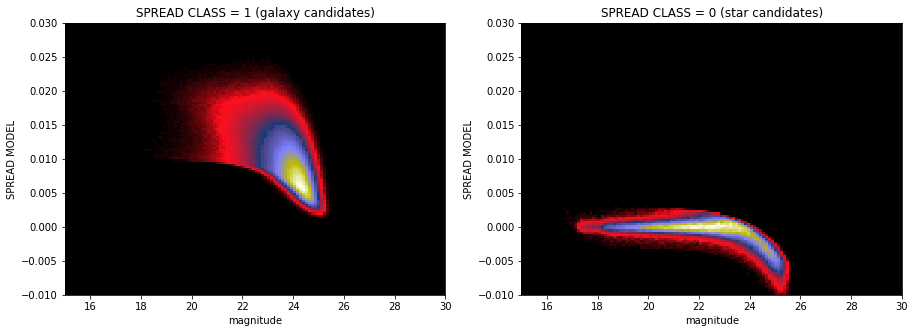

In [17]:
# See whether we can better see the galaxy and star distribution when splitting the data
# according to SPREAD_CLASS

mask_galaxies = mask & (dd['SPREAD_CLASS']==1)

figure(figsize=[15,5])
subplot(121)
_ = hist2d(dd['MAG_AUTO'][mask_galaxies], dd['SPREAD_MODEL'][mask_galaxies], range=[[15, 30], [-0.01, 0.03]],
           bins=128, cmap='gist_stern')
_ = xlabel('magnitude')
_ = ylabel('SPREAD MODEL')
_ = title('SPREAD CLASS = 1 (galaxy candidates)')

mask_stars = mask & (dd['SPREAD_CLASS']==0)

subplot(122)
_ = hist2d(dd['MAG_AUTO'][mask_stars], dd['SPREAD_MODEL'][mask_stars], range=[[15, 30], [-0.01, 0.03]],
           bins=128, cmap='gist_stern')
_ = xlabel('magnitude')
_ = ylabel('SPREAD MODEL')
_ = title('SPREAD CLASS = 0 (star candidates)')

### Look at (validation) star catalog
The PSF model was created using stars detected and selected on single-exposure images. In fact, a random sub-set of 80% of all stars was used to create the PSF model, 20% are kept as vaidation set, which we willl look at here.

The validation stars are stored in a separate file, which is the union of all single-exposure selected validation stars.

#### Two methods to load fits table

In [21]:
from astropy.io import fits

In [22]:
stars_cat = fits.getdata('./catalogue_CFIS_W3/output/run_sp_MsPl/mccd_merge_starcat_runner/output/full_starcat-0000000.fits')

In [23]:
from astropy.table import Table

In [24]:
stars_cat = Table.read('./catalogue_CFIS_W3/output/run_sp_MsPl/mccd_merge_starcat_runner/output/full_starcat-0000000.fits', hdu=2)

In [25]:
stars_cat

X,Y,RA,DEC,E1_PSF_HSM,E2_PSF_HSM,SIGMA_PSF_HSM,E1_STAR_HSM,E2_STAR_HSM,SIGMA_STAR_HSM,FLAG_PSF_HSM,FLAG_STAR_HSM,CCD_NB
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-5655.07139512,5279.2147391,217.826635821,54.7784425965,0.06664546013,-0.0491350983819,1.5797637701,0.0601293991257,-0.0343673937534,1.5556344986,0.0,0.0,0.0
-5343.00973444,5704.9266912,217.79871106,54.8004334113,0.0579269330937,-0.0412928083092,1.55842542648,0.0836421562487,-0.0378978593604,1.54261600971,0.0,0.0,0.0
-5678.4122636,9409.45421753,217.827821044,54.9904294629,0.0477651147762,-0.0836767702194,1.6429502964,0.00382556588989,-0.0547419280639,1.59054434299,0.0,0.0,0.0
-6025.91394527,7109.66138861,217.859368137,54.8722233598,0.0587158335639,-0.0418072725506,1.53684616089,0.0748434025324,-0.0533547096519,1.56828808784,0.0,0.0,0.0
-5496.53570339,7689.44128496,217.811933263,54.902227985,0.0605096155638,-0.0506556021889,1.5530987978,0.0486008481116,-0.0251558256847,1.54899036884,0.0,0.0,0.0
-5667.52779931,5639.92700773,217.8276679,54.796951981,0.0618627309605,-0.044615643014,1.56483709812,0.0675178426986,-0.0372721199731,1.51932609081,0.0,0.0,0.0
-4862.05607218,7799.66017008,217.755168889,54.9081554392,0.0658798207917,-0.0534269530951,1.55882918835,0.0557604966042,-0.0443908389828,1.54191803932,0.0,0.0,0.0
-4860.30288579,6688.29410732,217.755355976,54.8511116046,0.0547219202098,-0.0369558624722,1.53644156456,0.0608159599903,-0.0399401252211,1.55549776554,0.0,0.0,1.0
-5846.11715797,8876.38993166,217.84295433,54.9629910457,0.0356130450385,-0.0598745001003,1.59124934673,0.0417298177617,-0.0421883820936,1.56126463413,0.0,0.0,1.0


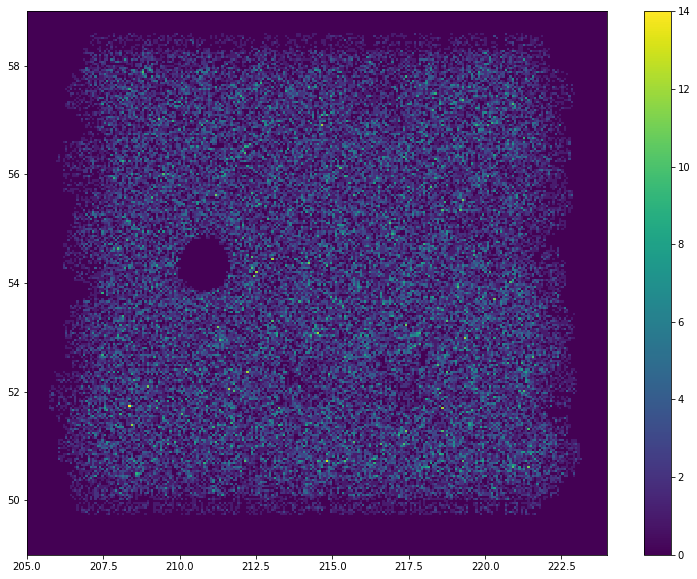

In [27]:
# Plot spatial distribution
# Patterns can be seen that reflect the survey strategy of using large dithers. A given star appears on
# typically three exposures with varying PSF, since the position in the focal plane as well as the
# observing conditions change. The number of exposures also varies. In particular at the borders of the field
# we can see this decreased depth, and also the geometry of the MegaCAM CCD mosaic with the 4 new "ear" CCDs.

figure(figsize=(13,10))
hist2d(stars_cat['RA'], stars_cat['DEC'], range=[[205, 224], [49, 59]], bins=256);
colorbar()

Next time: look a the response matrix, do some systematics tests